This is a clean version of the implementation as described in "Automating Assessment of Silver-enhanced in situ Hybridization for Evaluation of Cancer Properties"

There may be bad design choices; this notebook will not be updated.

# Initialization

In [2]:
import cv2, os
import numpy as np

import handling
import utils

In [3]:
import matplotlib.pyplot as plt
# convenience function to show RGB images in the body of the notebook
def imshow(arr):
    plt.figure()
    plt.axis('off')
    if len(arr.shape) == 2:
        plt.imshow(arr, cmap='gray')
        return
    if arr.shape[2] == 1:
        plt.imshow(arr, cmap='gray')
        return
    plt.imshow(arr)
    plt.show()

In [4]:
import valis
valis.registration.init_jvm()

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


JVM has been initialized. Be sure to call registration.kill_jvm() or slide_io.kill_jvm() at the end of your script.


In [5]:
path_shared = "/mnt/d/uni/THESIS/09816" # absolute or relative path to directory containing slides

# slide names WITHOUT extension
ecad_slide_name = 'VE0D6A800067E3'
p63_slide_name =  'VE0D6A800067E4'
sish_slide_name = 'VE0D6A800069B1'

path_ecad = os.path.join(path_shared, ecad_slide_name+'.mrxs')
wrap_ecad = handling.mrxs_wrapper(path_ecad)
path_p63 = os.path.join(path_shared, p63_slide_name+'.mrxs')
wrap_p63 = handling.mrxs_wrapper(path_p63)
path_sish = os.path.join(path_shared, sish_slide_name+'.mrxs')
wrap_sish = handling.mrxs_wrapper(path_sish)

# Image preparation

In [6]:
utils.match_samples(wrap_ecad, wrap_sish)

[(2, 4), (0, 3), (3, 2), (1, 0), (4, 5)]

In [7]:
utils.match_samples(wrap_p63, wrap_sish)

[(0, 2), (1, 4), (3, 3), (2, 0), (4, 5)]

In [8]:
utils.match_samples(wrap_p63, wrap_ecad)

[(3, 0), (1, 2), (0, 3), (2, 1), (4, 4)]

With the program suggesting best matches, select the correct sample (in testing slides there was only one). It's usually at the top so has a high index.

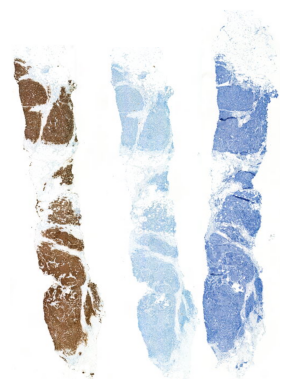

In [9]:
lvl = 6
ecad_element = 4
p63_element =  4
sish_element = 5

sish_object = wrap_sish.obj_at_lvl([sish_element], lvl+1)
ecad_object = wrap_ecad.obj_at_lvl([ecad_element], lvl)
p63_object =  wrap_p63.obj_at_lvl( [p63_element],  lvl)
target_h = max(sish_object.shape[0],ecad_object.shape[0],p63_object.shape[0])

current_h, current_w, c = ecad_object.shape
if current_h<target_h:
    ecad_object = np.concatenate([np.full((target_h-current_h,current_w,c),255),ecad_object],axis=0)
    
current_h, current_w, c = p63_object.shape
if current_h<target_h:
    p63_object = np.concatenate([np.full((target_h-current_h,current_w,c),255),p63_object],axis=0)
    
current_h, current_w, c = sish_object.shape
if current_h<target_h:
    sish_object = np.concatenate([np.full((target_h-current_h,current_w,c),255),sish_object],axis=0)


disp = np.concatenate([ecad_object,
                       p63_object,
                       sish_object],
                      axis = 1)
imshow(disp)

After the correct samples are selected, they are also saved separately for map alignment. Save level will influence accuracy and required RAM.

In [10]:
save_lvl = 3

valis.slide_io.save_ome_tiff(wrap_sish.obj_at_lvl([sish_element],save_lvl+1), os.path.join(path_shared,'cropped',sish_slide_name+'_groi.ome.tiff'), tile_wh=512, compression='lzw')
valis.slide_io.save_ome_tiff(wrap_ecad.obj_at_lvl([ecad_element],save_lvl),   os.path.join(path_shared,'cropped',ecad_slide_name+'_groi.ome.tiff'), tile_wh=512, compression='lzw')
valis.slide_io.save_ome_tiff( wrap_p63.obj_at_lvl([p63_element], save_lvl),   os.path.join(path_shared,'cropped',p63_slide_name +'_groi.ome.tiff'), tile_wh=512, compression='lzw')

saving /mnt/d/uni/THESIS/09816/cropped/VE0D6A800069B1.ome.tiff (1176 x 5568 and 4 channels)

[====================================================================================================] 100.0% in 0.924 seconds
Complete

saving /mnt/d/uni/THESIS/09816/cropped/VE0D6A800067E3.ome.tiff (1472 x 5024 and 4 channels)

[====================================================================================================] 100.0% in 0.726 seconds
Complete

saving /mnt/d/uni/THESIS/09816/cropped/VE0D6A800067E4.ome.tiff (1408 x 4992 and 4 channels)

[====================================================================================================] 100.0% in 0.763 seconds
Complete



# Using VALIS for alignment

In [11]:
registrar = valis.registration.Valis(os.path.join(path_shared,'crops'), 'temp/', max_processed_image_dim_px=1200,
                                     reference_img_f=os.path.join(path_shared,'crops',sish_slide_name+'.ome.tiff'))

/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Can't find slide file associated with xtra
  warnings.warn(warning_msg, warning_type)
/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: max_image_dim_px is 850 but needs to be less or equal to 1200. Setting max_image_dim_px to 1200
  warnings.warn(warning_msg, warning_type)


In [12]:
rigid_registrar, non_rigid_registrar, summary_df = registrar.register()


==== Converting images



  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

No series provided. Selecting series with largest image, which is series 0
Converting slide to pyvips image



 33%|████████████████████████████▎                                                        | 1/3 [00:05<00:11,  5.80s/it]

No series provided. Selecting series with largest image, which is series 0
Converting slide to pyvips image



 67%|████████████████████████████████████████████████████████▋                            | 2/3 [00:09<00:04,  4.38s/it]

No series provided. Selecting series with largest image, which is series 0
Converting slide to pyvips image



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.08s/it]
/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Smallest image is less than max_image_dim_px. parameter max_image_dim_px is being set to 624
  warnings.warn(warning_msg, warning_type)
/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: parameter max_processed_image_dim_px also being updated to 624
  warnings.warn(warning_msg, warning_type)



==== Processing images



  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

No series provided. Selecting series with largest image, which is series 0


/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Cannot find channel 'dapi' in /mnt/d/uni/THESIS/09816/crops/VE0D6A800067E3_groi.ome.tiff. Using channel 0
  warnings.warn(warning_msg, warning_type)
 33%|████████████████████████████▎                                                        | 1/3 [00:01<00:03,  1.79s/it]

No series provided. Selecting series with largest image, which is series 0


/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Cannot find channel 'dapi' in /mnt/d/uni/THESIS/09816/crops/VE0D6A800067E4_groi.ome.tiff. Using channel 0
  warnings.warn(warning_msg, warning_type)
 67%|████████████████████████████████████████████████████████▋                            | 2/3 [00:03<00:01,  1.66s/it]

No series provided. Selecting series with largest image, which is series 0


/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Cannot find channel 'dapi' in /mnt/d/uni/THESIS/09816/crops/VE0D6A800069B1_groi.ome.tiff. Using channel 0
  warnings.warn(warning_msg, warning_type)
100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.61s/it]



==== Normalizing images



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.65it/s]



==== Rigid registraration



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.72it/s]
/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: ('The reference was specified as VE0D6A800069B1 ', 'but `align_to_reference` is `False`, and so images will be aligned serially. ', 'If you would like all images to be directly aligned to VE0D6A800069B1, then set `align_to_reference` to `True`')
  warnings.warn(warning_msg, warning_type)



======== Detecting features



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.78s/it]



======== Matching images



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]



======== Sorting images


======== Calculating transformations



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 5291.38it/s]



======== Rigid registration complete in 12.547 seconds


==== Non-rigid registraration


======== Preparing images for non-rigid registration



  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

Converting slide to pyvips image



100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1626.96it/s]


No series provided. Selecting series with largest image, which is series 0


/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Cannot find channel 'dapi' in /mnt/d/uni/THESIS/09816/crops/VE0D6A800067E3_groi.ome.tiff. Using channel 0
  warnings.warn(warning_msg, warning_type)
 33%|████████████████████████████▎                                                        | 1/3 [00:03<00:06,  3.12s/it]

Converting slide to pyvips image



100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2016.73it/s]


No series provided. Selecting series with largest image, which is series 0


/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Cannot find channel 'dapi' in /mnt/d/uni/THESIS/09816/crops/VE0D6A800067E4_groi.ome.tiff. Using channel 0
  warnings.warn(warning_msg, warning_type)
 67%|████████████████████████████████████████████████████████▋                            | 2/3 [00:06<00:03,  3.48s/it]

Converting slide to pyvips image



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3116.12it/s]


No series provided. Selecting series with largest image, which is series 0


/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Cannot find channel 'dapi' in /mnt/d/uni/THESIS/09816/crops/VE0D6A800069B1_groi.ome.tiff. Using channel 0
  warnings.warn(warning_msg, warning_type)
100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.24s/it]
/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: ('The reference was specified as VE0D6A800069B1 ', 'but `align_to_reference` is `False`, and so images will be aligned serially. ', 'If you would like all images to be directly aligned to VE0D6A800069B1, then set `align_to_reference` to `True`')
  warnings.warn(warning_msg, warning_type)
100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]



======== Non-rigid registration complete in 9.574 seconds


==== Measuring error



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s]


# Extra Preparation

In [15]:
hit_kernel = np.array([[0,0,0],
                       [0,1,0],
                       [0,0,0]], np.uint8)
miss_kernel = np.array([[1,1,1],
                        [1,0,1],
                        [1,1,1]], dtype=np.uint8)

def mask_dye(img):
    return cv2.inRange(img, (0,8,8), (40,224,160)) + cv2.inRange(img, (155,8,8), (179,224,160))

def expand_mask(mask):
    hit = cv2.morphologyEx(mask, cv2.MORPH_ERODE, hit_kernel)
    miss = cv2.morphologyEx(cv2.bitwise_not(mask), cv2.MORPH_ERODE, miss_kernel)
    hitormiss = cv2.bitwise_and(hit, miss)
    mask = mask - hitormiss
    
    mask = cv2.dilate(mask, np.full((9,9),1))
    for i in range(growth_iter):
        mask = cv2.medianBlur(mask, 7)
    mask = cv2.erode(mask, np.full((5,5),1))
    return mask

def create_mask(img):
    mask = mask_dye(img)
    mask = expand_mask(mask)
    return mask

def wrap_mask_at_lvl(wrap, loc, lvl):
    obj = wrap.obj_at_lvl(loc, lvl)
    obj = cv2.cvtColor(obj, cv2.COLOR_RGB2HSV)
    mask = mask_dye(obj)
    mask = expand_mask(mask)
    return mask

In [17]:
def distance(x1,x2,y1,y2):
    value = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    return value


def filter2Dimg(freq_img,u=100,s=20):
    x_center = freq_img.shape[1] / 2.0
    y_center = freq_img.shape[0] / 2.0

    filt = np.zeros_like(freq_img)
    for x in range(freq_img.shape[1]):
        for y in range(freq_img.shape[0]):
            dist = distance(x,x_center,y,y_center)

            G = 1 / (s * (2 * np.pi)**0.5) * np.exp(-0.5*((dist-u)/s)**2) * s / 0.4

            filt[y,x] = G
    freq_img_out = freq_img * filt
    return freq_img_out

def stretch_uint8(arr):
    proc = arr.copy()
    proc = proc - np.min(proc)
#     proc = proc * (255/np.max(proc))
    return proc.astype(np.uint8)

In [18]:
def mask_to_centers(mask):
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = []
    for cnt in cnts:
        x,y,w,h = cv2.boundingRect(cnt)
        out.append((x+w//2, y+h//2))
        # inject here for multiple counts per detection
    return out

def expand_cnt(ori, x):
    cnt = ori.copy()
    left_margin = cnt[cnt[:,:,0].argmin()][0][0]
    top_margin = cnt[cnt[:,:,1].argmin()][0][1]
    cnt[:,:,0] = cnt[:,:,0] - left_margin +x
    cnt[:,:,1] = cnt[:,:,1] - top_margin  +x
    
    _,_,w,h = cv2.boundingRect(cnt)
    flash = np.zeros((h+2*x,w+2*x))
    flash = cv2.drawContours(flash, [cnt], -1, 255, 1)
    flash = cv2.dilate(flash, np.ones((x,x))).astype(np.uint8)
    cnts, _ = cv2.findContours(flash, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    out = cnts[0]
    out[:,:,0] = out[:,:,0] + left_margin -x
    out[:,:,1] = out[:,:,1] + top_margin  -x
    return out

def get_cnt_info(cnt):
    M = cv2.moments(cnt)
    if not M["m00"]:
        M["m00"] = 1e-8
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    convex = cv2.convexHull(cnt)
    (x,y),radius = cv2.minEnclosingCircle(cnt)
    
    x,y,w,h = cv2.boundingRect(cnt)
    length_ratio = max(h,w)/min(h,w)
    
    return {
        'mcent':np.array([cX, cY]),
        'ccent':np.array([x,y]),
        'radius':radius,
        'aspect':length_ratio,
        'area':cv2.contourArea(cnt)
    }

def dist_2xy(xy1,xy2):
    return np.sqrt(np.sum((xy1-xy2)**2))

def median_growth(arr, ksize, it):
    out = arr.copy()
    for i in range(it):
        out = cv2.medianBlur(out, ksize)
    return out

In [19]:
def get_red_black(cell_hsv):
    mask_dot = cv2.dilate((cell_hsv[:,:,2] < 150).astype(np.uint8), np.ones((3,3)))
    mask_dot = np.where(mask_dot, 255, 0).astype(np.uint8)
    broad_red = cv2.bitwise_not((cell_hsv[:,:,0]>130).astype(np.uint8))*255
    broad_red = cv2.dilate(broad_red, np.ones((9,9)))
    dot_diff = mask_dot&broad_red

    mask_red = np.where(dot_diff==2, 255, 0).astype(np.uint8)
    mask_black = np.where(dot_diff==1, 255, 0).astype(np.uint8)
    return mask_red, mask_black

def dedot(cell_hsv): # essentially Figure 7
    dotless_base = cell_hsv[:,:,1].copy()
    dotloc = np.where(cv2.dilate(mask_dot, np.ones((9,9))), dotless_base, 0)
    dotloc = cv2.dilate(dotloc, np.ones((3,3)))
    dotloc = median_growth(dotloc, 9, 3)
    dotloc = cv2.blur(dotloc, (9,9))
    dotless = np.where(cv2.dilate(mask_dot, np.ones((1,1))), dotloc, dotless_base)
    return dotless

# Pipeline Iteration

In [22]:
from math import ceil

def sish_serve(start_x, start_y, x, y, tile_size):
    target_xywh = np.array([tile_size*x, tile_size*y, tile_size, tile_size])
    region_sish = np.array(wrap_sish.image.read_region((target_xywh[0]+start_x,target_xywh[1]+start_y),0,(target_xywh[2],target_xywh[3])))[:,:,:3]
    
    map_xywh = wrap_sish._convert_scale_from_to(target_xywh,0,4)
    return region_sish, map_xywh

def tileset_iterator(slide_dict, slide_binds, tile_size = 1024):
    bounds = wrap_sish._bounds_at_lvl([5],0)
    height, width = bounds['h'], bounds['w']
    start_x, start_y = bounds['x'], bounds['y']
    v_tiles = ceil(height/tile_size)
    h_tiles = ceil(width/tile_size)
    
#     mask_ecad = wrap_mask_at_lvl(wrap_ecad, [4], 3)
#     mask_p63 =  wrap_mask_at_lvl(wrap_p63,  [4], 3)
    
#     mask_warped_ecad = slide_dict[slide_binds['ecad']].warp_img(mask_ecad)
#     mask_warped_p63  = slide_dict[slide_binds['p63']].warp_img(mask_p63)
    
    warped_ecad = slide_dict[slide_binds['ecad']].warp_slide(0)
    warped_p63  = slide_dict[slide_binds['p63']].warp_slide(0)
    
    print('will start iter')
    
    for x in range(v_tiles):
        for y in range(h_tiles):
            region_sish, map_xywh = sish_serve(start_x, start_y, x,y,tile_size)

            try:
                region_ecad = warped_ecad.extract_area(*map_xywh).numpy()
                region_ecad = cv2.resize(region_ecad, (tile_size, tile_size))
            
                region_p63  = warped_p63.extract_area(*map_xywh).numpy()
                region_p63 = cv2.resize(region_p63, (tile_size, tile_size))
            except:
                continue
                
            out = {
                'sish':region_sish,
                'ecad':region_ecad,
                'p63': region_p63,
                'loc': (x,y)
            }

            yield out

The variables at the beginning of the next snippet can be edited to influence cell detection

In [23]:
sibling_cutoff = 10

area_limits = range(2000, 5400)
radius_limits = range(20, 60)
scan = [3,4,5,6,7]
cell_expansion = 6

def process_tileset(tileset, strict=False):
    cell = tileset['cell'][:,:,:3].copy()
    if strict:
        cell = np.where(np.stack([tileset['map']]*4, axis=2), cell, 255)
    cell_hsv = cv2.cvtColor(cell, cv2.COLOR_RGB2HSV)
    mask_red, mask_black = get_red_black(cell_hsv)
    locate_red = mask_to_centers(mask_red)
    locate_black = mask_to_centers(mask_black)
    
    dotless = dedot(cell_hsv)
    freq_img = np.fft.fft2(dotless)
    freq_img = np.fft.fftshift(freq_img)
    freq_img_out = filter2Dimg(freq_img,u=7*10,s=30)
    freq_img_out = np.fft.ifftshift(freq_img_out)
    img_out = np.fft.ifft2(freq_img_out)
    
    combo = dict()
    last_id = -1
    for cutoff in scan: # Figure 8
        border_threshold = np.where(img_out.real<cutoff, 0, 255).astype(np.uint8)
        border_threshold = cv2.erode(border_threshold, np.ones((3,3)))
        border_threshold = median_growth(border_threshold, 5, 15)
        cnts, _ = cv2.findContours(border_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in cnts:
            convex = cv2.convexHull(cnt)
            cnt_info = get_cnt_info(convex)
            if int(cnt_info['radius']) not in radius_limits:
                continue
            if int(cnt_info['area']) not in area_limits:
                continue

            orphan = True
            for i in combo:
                if dist_2xy(combo[i]['acent'], cnt_info['mcent']) < sibling_cutoff:
                    combo[i]['acent'] = (combo[i]['acent']+cnt_info['mcent'])/2
                    combo[i]['info'][cutoff] = {'info':cnt_info, 'cnt':cnt}
                    combo[i]['refs'] += 1
                    orphan = False
                    break
            if orphan:
                last_id += 1
                combo[last_id] = {"refs":1, "acent":cnt_info['mcent'], "info":{cutoff:{'info':cnt_info, 'cnt':cnt}}}
    for i in combo:
        combo[i]['refs'] = combo[i]['refs']/len(scan)
    
    last_id = -1
    final = dict()
    for i in combo:
        if combo[i]['refs'] < 0.5:
            continue
        area_opt = dict()
        for opt in combo[i]['info']:
            new_cnt = expand_cnt(cv2.convexHull(combo[i]['info'][opt]['cnt']), 7)
            new_info = get_cnt_info(new_cnt)
            area_opt[int(new_info['area'])] = (new_cnt, new_info)
        if not len(area_opt)%2:
            del area_opt[int(min(list(area_opt)))]
        final_cnt, final_info = area_opt[int(np.max(list(area_opt)))]
        
        final_info['black'] = 0
        for dot in locate_black:
            is_in_cell = cv2.pointPolygonTest(final_cnt,dot,False) +1
            if is_in_cell:
                final_info['black'] +=1
        if not final_info['black']:
            continue
                
        final_info['red'] = 0
        for dot in locate_red:
            is_in_cell = cv2.pointPolygonTest(final_cnt,dot,False) +1
            if is_in_cell:
                final_info['red'] +=1
        if not final_info['red']:
            continue
        
        last_id +=1
        final[last_id] = {'cnt':final_cnt, 'info':final_info}
    return final

In [ ]:
slide_binds = {
    'sish':sish_slide_name,
    'ecad':ecad_slide_name,
    'p63': p63_slide_name
}

cells = dict()

for tileset in tileset_iterator(registrar.slide_dict, slide_binds):
    mask_ecad = create_mask(cv2.cvtColor(tileset['ecad'], cv2.COLOR_RGB2HSV))
    if 255 not in np.unique(mask_ecad):
        continue
    
    print(f"tile with cancer presence:{tileset['loc']}")
    current = {
        'map':create_mask(cv2.cvtColor(tileset['ecad'], cv2.COLOR_RGB2HSV))
              -create_mask(cv2.cvtColor(tileset['p63'], cv2.COLOR_RGB2HSV)),
        'cell':tileset['sish']}
    results = process_tileset(current)
    if not results:
        print("no valid cells found")
        continue
    cells[tileset['loc']] = results
    out = tileset['sish'][:,:,:3].copy()
    
    for i in results:
        out = cv2.drawContours(out, [results[i]['cnt']], -1, (0,255,0), 2)
        BR_ratio = f"{results[i]['info']['black']/results[i]['info']['red']:.2f}"
        out = cv2.putText(out, BR_ratio, results[i]['info']['mcent'], cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 2)
    imshow(out)